# Training a model with PyTorch

In this notebook, we train a model to correctly classify with high accuracy whether an image contains an invasive species of hydrangea.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit
%matplotlib inline

## Load Datasets

We load the Invasive Species Dataset. It assumes the dataset is stored according to format of an ImageFolder dataset.

In [9]:
from torchvision import datasets, models, transforms
import os
cwd = os.getcwd()

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(866), # 866 by 1154
        transforms.Scale(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomSizedCrop(866), # 866 by 1154
        transforms.Scale(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100
model_save_dir = os.path.join(cwd,"model_params")


In [10]:
print(dset_classes)
print(len(dsets['train']))

['0', '1']
2142


## Image sample
Plot an image just to make sure we have something that makes sense.

torch.Size([4, 3, 224, 224])


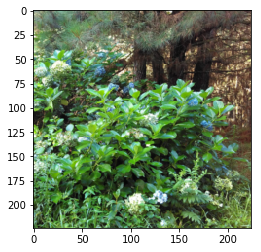

In [11]:
import torchvision.utils
import matplotlib.pyplot as plt

inputs, classes = next(iter(dset_loaders['train']))
to_pil = torchvision.transforms.ToPILImage()
print(inputs.size())
img = to_pil(inputs[0])
plt.imshow(img)

## Training
We use the following helper function to help us train a model

In [12]:
def train(model, loss_fn, loader, optimizer, num_epochs = 1, print_every=100):
    loss_history = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_data = loss.data[0]
            loss_history.append(loss_data)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss_data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_history

def check_accuracy(model, loader, return_errors=False, is_testing=False):
    if not is_testing:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        if return_errors:
            for i,x_i in enumerate(x):
                if (preds[i]!=y[i])[0] == 1:
                    incorrect_x[preds[i][0]].append(x_i)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x

In [15]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

### Tune Hyperparameters
Here we run the learning rate, regularization, and betas for Adam optimizer for 1 epoch.

In [16]:
# tune the hyperparameters

# best acc 0.9703872437357631, beta0 0.95, beta1 0.995, reg 0.0018627520611745705, lr -4.05194392122697

lr_step = 1
lr_range = np.arange(-5,-1,lr_step)
learning_rates = [10**np.random.uniform(n,n+lr_step) for n in lr_range]
reg_step = 1
reg_range = np.arange(-7,-1,reg_step)
regs = [10**np.random.uniform(n,n+reg_step) for n in reg_range]
beta0s = [0.9,0.95]
beta1s = [0.99, 0.995, 0.999]
best_acc = -1
best_beta0 = -1
best_beta1 = -1
best_reg = -1
best_lr = -1

for lr in learning_rates:
    for reg in regs:
        for beta0 in beta0s:
            for beta1 in beta1s:
                model = models.vgg13(pretrained=True)
                model.classifier[6].out_features = 2
                model.cuda()
                loss_fn = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta0, beta1), weight_decay=reg)
                loss_history = train(model, loss_fn, dset_loaders["train"], optimizer, num_epochs=1)
                acc, _ = check_accuracy(model, dset_loaders["val"])
                if acc > best_acc:
                    best_acc = acc
                    best_beta0 = beta0
                    best_beta1 = beta1
                    best_reg = reg
                    best_lr = lr
                    print("check acc {}, beta0 {}, beta1 {}, reg {}, lr {}".format(acc, beta0, beta1, reg, np.log10(lr)))


print("best acc {}, beta0 {}, beta1 {}, reg {}, lr {}".format(best_acc, best_beta0, best_beta1, best_reg, np.log10(best_lr)))

Starting epoch 1 / 1
t = 100, loss = 0.3220
t = 200, loss = 0.6204
t = 300, loss = 0.1409
t = 400, loss = 0.0001
t = 500, loss = 0.4362
Checking accuracy on validation set
Got 702 / 737 correct (95.25)
check acc 0.9525101763907734, beta0 0.9, beta1 0.99, reg 1.0911171725588124e-07, lr -4.497319261526658
Starting epoch 1 / 1
t = 100, loss = 0.7065
t = 200, loss = 0.0854
t = 300, loss = 1.0757
t = 400, loss = 0.0869
t = 500, loss = 0.8899
Checking accuracy on validation set
Got 665 / 737 correct (90.23)
Starting epoch 1 / 1
t = 100, loss = 0.0841
t = 200, loss = 0.0075
t = 300, loss = 1.0564
t = 400, loss = 1.0049
t = 500, loss = 0.5627
Checking accuracy on validation set
Got 694 / 737 correct (94.17)
Starting epoch 1 / 1
t = 100, loss = 1.4698
t = 200, loss = 0.0003
t = 300, loss = 0.1319
t = 400, loss = 0.0586
t = 500, loss = 0.2056
Checking accuracy on validation set
Got 671 / 737 correct (91.04)
Starting epoch 1 / 1
t = 100, loss = 1.6605
t = 200, loss = 0.0107
t = 300, loss = 0.1335

Given the results from the training, we train one model on the best hyperparameters and save the results:

In [17]:
# Here we use transfer learning to create a good model based on vggnet.
# best acc 0.9703872437357631, beta0 0.95, beta1 0.995, reg 0.0018627520611745705, lr -4.05194392122697
model = models.vgg13(pretrained=True)
model.classifier[6].out_features = 2
model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10**-4.05194, betas=(0.95, 0.995), weight_decay=0.00186)

loss_history = train(model, loss_fn, dset_loaders["train"], optimizer, num_epochs=5)
acc, incorrects = check_accuracy(model, dset_loaders["val"], True)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Starting epoch 1 / 5
t = 100, loss = 0.1730
t = 200, loss = 1.5074
t = 300, loss = 0.0057
t = 400, loss = 0.3020
t = 500, loss = 0.1487
Starting epoch 2 / 5
t = 100, loss = 0.1515
t = 200, loss = 0.2293
t = 300, loss = 0.0206
t = 400, loss = 0.0158
t = 500, loss = 0.0290
Starting epoch 3 / 5
t = 100, loss = 0.0125
t = 200, loss = 0.1114
t = 300, loss = 1.7722
t = 400, loss = 0.3834
t = 500, loss = 0.0213
Starting epoch 4 / 5
t = 100, loss = 0.0000
t = 200, loss = 0.0000
t = 300, loss = 0.0347
t = 400, loss = 0.0484
t = 500, loss = 0.0139
Starting epoch 5 / 5
t = 100, loss = 0.0165
t = 200, loss = 0.2844
t = 300, loss = 0.0866
t = 400, loss = 0.0178
t = 500, loss = 0.5119
Checking accuracy on validation set
Got 699 / 737 correct (94.84)
False negatives: 27
False positives: 11


We can see that it is an excellent model, but we need to do more work in order to make it higher on the scoreboard for the Kaggle competition.

In [18]:
torch.save(model.state_dict(), model_save_dir)

In [ ]:
# Plot the training losses
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

The loss here is most likely because it is zoomed it. With the pretrained ResNet, losses start out low, and so we don't get the typical hockey-stick figure. However, the small surges are interesting. Need an explanation here.

## False Positives and False Negatives
Here we plot all of the false positives and false negatives.

In [ ]:
def plot_images(imgs, label):
    num_images = len(imgs)
    fig = plt.figure(figsize=(32, 32)) 
    for j in range(num_images):
        ax = plt.subplot(num_images//4+1, 4, j+1)
        ax.axis('off')
        ax.set_title('pred: {}'.format(label))
        to_pil = torchvision.transforms.ToPILImage()
        img = to_pil(imgs[j])
        plt.imshow(img)


plot_images(incorrects[0], "0")
plot_images(incorrects[1], "1")

## Saliency Maps
Let's now take a look at the saliency maps for the false positives and false negatives. (Thank you assignment 3!)

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X.type(gpu_dtype), requires_grad=True)
    y_var = Variable(y)
    saliency = None
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    scores = model(X_var)
    loss = loss_fn(scores, y_var)
    loss.backward()
    saliency = X_var.grad.data.abs().max(dim=1)[0].squeeze()
    return saliency

In [ ]:
def show_saliency_maps(X, y, name):
    to_pil = torchvision.transforms.ToPILImage()
    X_tensor = torch.cat([x.unsqueeze(0) for x in X], 0)
    y_tensor = y#torch.cuda.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = X_tensor.size()[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(to_pil(X_tensor[i]))
        plt.axis('off')
        plt.title(name)
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

### False positives saliency maps

In [ ]:
false_positives = incorrects[1]
show_saliency_maps(false_positives, torch.zeros(len(false_positives)).type(torch.cuda.LongTensor), '1')

### False negatives saliency maps

In [ ]:
false_negatives = incorrects[0][0:4]
show_saliency_maps(false_negatives, torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0')
false_negatives = incorrects[0][4:8]
show_saliency_maps(false_negatives, torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0')
false_negatives = incorrects[0][8:13]
show_saliency_maps(false_negatives, torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0')

## Image processing
From the saliency maps above, we can see that images are misclassified in the false positive case because the similar leaves that are highlighted in the map might be triggering the classification. For the false negative case, which has many more instances than in the false positive, we can see that some of the misclassifications are a scaling issue, where the images are too far in the background. In other cases, the hydrangeas are being choked by weeds, and so they aren't completely surrounded by their own leaves. However, it is interesting that the maps show that the classifier still correctly identifies where the hydrangeas are, even if the last layer classifies the image as a false.

We can try to chop up the images into equally-sized squares and do a model-ensemble-like scoring where we combine the scores from the various sections of the image. The scoring would be such that an image section that returns a high probability would carry more weight than one of a medium probability. However, this is very similar to what SSD is trying to accomplish, so instead that is tried here.